# An initial exploration of twitter sentiment analysis

Twitter is a fascinating, if somewhat terrifying, resource which can be valuable in a number of different ways. One particular use of twitter is sentiment analysis: what does the general public of twitter posters feel about a given topic? 

This can be any number of topics:
- sentiment about politicians can be valuable for polling insights
- sentiment about current events such as climate change can be valuable for advocacy and policy work
- sentiment about companies can be valuable for relating public sentiment to the stock market
- sentiment about products or services can give insight for the companies that sell them

In this notebook, I demonstrate how to get started with sentiment analysis. I use the following tech stack:
- tweepy (the python twitter API)
- huggingface transformers in pytorch (for sentiment analysis)
- pandas (for data analysis/wrangling)
- seaborn (for data visualisation)

I'll also discuss some of the pitfalls of twitter sentiment analysis and how the basic work in this notebook could be expanded upon.

In [1]:
# Adding in dependencies for reproducibility
#!pip install tweepy
#!pip install tqdm
#!pip install transformers
#!pip install scipy
#!pip install torch torchvision torchaudio

In [2]:
import tweepy
import requests
from tqdm import tqdm
import torch
import pandas as pd

## Setting up authentication in tweepy
I've set up a twitter developer account, which gives me an access token that I have stored in a file. This token is necessary for pulling data from the twitter API. Here I initialise the tweepy client with my token read from file.

In [3]:
def get_token(filename):
    return open(filename).read().splitlines()[0]

In [4]:
# Get token from file and set up a client
twitter_token = get_token("/Users/hector/.twitter")
client = tweepy.Client(bearer_token=twitter_token,
                       wait_on_rate_limit=True)

## Getting tweets from last 7 days
Now I'm going to pull a selection of tweets from the last 7 days. Given the recent political turmoil here in the UK I've decided to see how twitter is feeling about our shortest serving prime minister, Liz Truss. I'll do this be searching for tweets that mention her user handle @trussliz.

Whilst the Paginator class allows a maximum of 100 results per page, we can technically iterate over the pages and retrieve a great number of tweets. As I'm just playing around I'll limit us to 5000 total tweets.

In [ ]:
query = '@trussliz'

recent_tweets = tweepy.Paginator(client.search_recent_tweets,
                                 query=query,
                                 expansions=['author_id', 'referenced_tweets.id',
                                             'referenced_tweets.id.author_id',
                                             'in_reply_to_user_id', 'attachments.media_keys',
                                             'entities.mentions.username'],
                                 tweet_fields=['id', 'text', 'author_id',
                                               'created_at', 'conversation_id', 'entities',
                                               'public_metrics','referenced_tweets'],
                                 max_results=100)

In [7]:
from IPython.display import clear_output, display

retrieved_tweets = []
tweets_fetched = 0
# Paginator returns multiple pages of tweets - can just iterate over this as much as needed
total_tweets_to_fetch = 5000
for response in recent_tweets:
    if tweets_fetched == total_tweets_to_fetch:
            break
        
    referenced_tweets = {
        referenced_tweet.id: referenced_tweet
        for referenced_tweet in response.includes["tweets"]
    }

    for tweet in response.data:
        text = tweet.text
        retweet = None
        reply = None
        
        # If this is a retweet, get the original tweet, as the tweepy API truncates it otherwise
        if tweet.referenced_tweets is not None:
            if text.startswith('RT'):
                text = referenced_tweets[tweet.referenced_tweets[0].id].text
                retweet = referenced_tweets[tweet.referenced_tweets[0].id].id
            else:
                try:
                    reply = referenced_tweets[tweet.referenced_tweets[0].id].id
                except:
                    print(f"Tweet id {tweet.id}")
                    print(f"Trying to access: {tweet.referenced_tweets[0].id}")
                    print(f"Referenced tweets {referenced_tweets}")
            
        retrieved_tweets.append({'id': tweet.id, 'text': text, 'retweet': retweet,
                                 'reply': reply, 'time': tweet.created_at})
        
        # Showing how many tweets fetched
        tweets_fetched += 1
        clear_output(wait=True)
        display(tweets_fetched)
        
        if tweets_fetched == total_tweets_to_fetch:
            break
        


5000

## Downloading a transformer model from Huggingface

Huggingface is fantastic community/platform which allows users to build, train, deploy, and share ML models in an open source manner. 

Transformers represent the state of the art when it comes to natural language processing tasks. Transformers are usually pre-trained on a general language task, before being fine-trained for a more specific task. Here I have download a transformer network that has been fine-tuned for sentiment analysis on twitter data.

You can find more details on this model, including a model card and accompanying paper, here: https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest



In [8]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax

Similarly to tweepy, huggingface requires an access token which will allow me to interact with the website. I use the huggingface transformers library to load the model, providing it with the name of the model I want and my access token.

In [9]:
hf_token = get_token("/Users/hector/.huggingface")
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL, use_auth_token=hf_token)
config = AutoConfig.from_pretrained(MODEL, use_auth_token=hf_token)

model = AutoModelForSequenceClassification.from_pretrained(MODEL, use_auth_token=hf_token)


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Here I define some utility functions: a preprocessor to strip replace user mentions and URLs, and a wrapper function that gets predictions from the downloaded model.

In [10]:
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)


def predict(text, tokenizer, model):
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    
    
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    
    ranking = np.argsort(scores)
    ranking = ranking[::-1]

    result = {config.id2label[ranking[i]]: scores[ranking[i]] for i in range(scores.shape[0])}
    
    return result

## Running sentiment analysis on tweets
Now I pass the tweets into the model and get a sentiment for each one.

In [11]:
scored_tweets = []
for tweet in tqdm(retrieved_tweets):
    # Get scores for each sentiment
    sentiment_scores = predict(tweet['text'], tokenizer, model)

    tweet.update(sentiment_scores)

    scored_tweets.append(tweet)

100%|█████████████████████████████████████| 5000/5000 [1:11:43<00:00,  1.16it/s]


In [57]:
df = pd.DataFrame(scored_tweets)

In [58]:
# Adding the maximum sentiment
df['Sentiment'] = df[['Neutral', 'Positive', 'Negative']].idxmax(axis="columns")

In [59]:
df['time'] = pd.to_datetime(df['time'])

In [61]:
df[['retweet', 'reply']] = df[['retweet', 'reply']].fillna(value=0)

df['retweet'] = df['retweet'].astype(int)
df['reply'] = df['reply'].astype(int)



## Inspecting the dataset we've created

In [91]:
df[df['reply']>0].head(30)

,id,text,retweet,reply,time,Neutral,Negative,Positive,Sentiment
0,1584102252171567105,"@benhabib6 @trussliz How many billions did the bank spend propping up the pound, ?I’ve forgotten",0,1583776704866455552,2022-10-23 08:39:42+00:00,0.649200,0.296402,0.054398,Neutral
4,1584102140871462912,@benhabib6 @trussliz https://t.co/vz0AkZRgoa,0,1583776704866455552,2022-10-23 08:39:16+00:00,0.873107,0.028034,0.098860,Neutral
6,1584102097061978112,@JustinWelby @trussliz Why are you praying for her? Absolutely ridiculous comment to make. You have shown your true colours here and they're blue,0,1583148896767070208,2022-10-23 08:39:05+00:00,0.056930,0.938204,0.004866,Negative
7,1584102089915236352,@OblackSalisu @pikapikapi08 @warsamegift @ClownWallstreet @MedvedevRussiaE @trussliz ..and I for freedom of any sovereign country.,0,1583865557111033856,2022-10-23 08:39:04+00:00,0.851430,0.040677,0.107893,Neutral
8,1584102079898955777,@Liseylox @SusanBanbury1 @benhabib6 @trussliz Yes.,0,1584042845970649088,2022-10-23 08:39:01+00:00,0.811697,0.020536,0.167768,Neutral
14,1584101948852011008,@elias_kioni @3_soprano @LLenaat @trussliz @Electra306 τα φοινικέλαια ειναι αντικουκου να ξέτε,0,1584101016269557760,2022-10-23 08:38:30+00:00,0.871827,0.029544,0.098629,Neutral
20,1584101856586104833,"@un @antonioguterres @potus @secblinken @deputysecstate @secdef @emmanuelmacron @trussliz @justintrudeau @melaniejoly &amp; the rest of the West: ""Russia (is) ... ready for negotiations!""\nhttps://t.co/epjRp84gEs",0,1583869494057107456,2022-10-23 08:38:08+00:00,0.890233,0.021157,0.088610,Neutral
22,1584101834641526785,@NileGardiner @BorisJohnson @trussliz What for a man who tried covering up Patterson's corruption or trying to promote a sexual predator or when he lied to the Queen then partied as she buried her\nhusband? I'd question your moral compass but it sounds like you've not got one.,0,1583888082788839424,2022-10-23 08:38:03+00:00,0.123210,0.871247,0.005543,Negative
29,1584101617132920832,@trussliz partying on our dime. It’s a disgrace. #ToriesOut https://t.co/jUul25c1B7,0,1584100260779294720,2022-10-23 08:37:11+00:00,0.053779,0.940463,0.005758,Negative
31,1584101593133518848,Really? AZsafe &amp; effective! @theresecoffey @CMO_England @uksciencechief @UKHSA @IndependentSage @MHRAgovuk @trussliz @maggie_erewash @RobertJenrick @OHID @NICEComms @NHSBSA @DHSCgovuk\n@Jeremy_Hunt @sheencr @RCPath @RCObsGyn @theRCN @RCPhysicians @RCSnews @RCollEM @rcgp @rcpsych https://t.co/LeTpHMefJM,0,1583917233339650048,2022-10-23 08:37:05+00:00,0.189274,0.009014,0.801712,Positive


In [85]:
pd.set_option('display.max_colwidth', None)
df['text'] = df['text'].str.wrap(200)
df.head(10)

,id,text,retweet,reply,time,Neutral,Negative,Positive,Sentiment
0,1584102252171567105,"@benhabib6 @trussliz How many billions did the bank spend propping up the pound, ?I’ve forgotten",0,1583776704866455552,2022-10-23 08:39:42+00:00,0.649200,0.296402,0.054398,Neutral
1,1584102250146070528,لا يمثل الإرهابيون في الجبهة الشعبية لتحرير تيغراي شعب تيغراي #DisarmTPLF #TPLFisTheCause @EU_Commission @eucopresident @vonderleyen @JanezLenarcic @USAmbUN @CanadaFP @eu_eeas @SFRCdems\n@SenateForeign @HouseForeign @eucopresident @JosepBorrellF @trussliz @UKParliament,1584061969954660352,0,2022-10-23 08:39:42+00:00,0.694927,0.261372,0.043701,Neutral
2,1584102249948930048,They plan to prevent the government from taking decisive action against the TPLF threat. Their plan didn't work. Not this time! #DisarmTPLF #TPLFMustGo @PowerUSAID @USAmbUN @CanadaFP @SFRCdems\n@SenateForeign @HouseForeign @eucopresident @JosepBorrellF @trussliz,1583899996901941248,0,2022-10-23 08:39:42+00:00,0.093921,0.899630,0.006450,Negative
3,1584102181850210304,TPLF est un mercenaire ! #DisarmTPLF #TPLFisTheCause @CanadaFP @eu_eeas @SFRCdems @SenateForeign @HouseForeign @eucopresident @JosepBorrellF @trussliz @UKParliament @CanadaFP @UN_HRC @vonderleyen\n@MikeHammerUSA @Reuters @AFP @bpolitics @BBCAfrica @AsstSecStateAF @CNNAfrica,1584062193402011648,0,2022-10-23 08:39:26+00:00,0.239950,0.748276,0.011773,Negative
4,1584102140871462912,@benhabib6 @trussliz https://t.co/vz0AkZRgoa,0,1583776704866455552,2022-10-23 08:39:16+00:00,0.873107,0.028034,0.098860,Neutral
5,1584102129353912321,Arrêtez d'être attaqué par la guerre par procuration ! #DisarmTPLF #TPLFisTheCause @eu_eeas @SFRCdems @SenateForeign @HouseForeign @eucopresident @JosepBorrellF @trussliz @UKParliament @CanadaFP\n@UN_HRC @vonderleyen @MikeHammerUSA @Reuters @AFP @bpolitics @BBCAfrica,1584062370238062592,0,2022-10-23 08:39:13+00:00,0.423350,0.557129,0.019521,Negative
6,1584102097061978112,@JustinWelby @trussliz Why are you praying for her? Absolutely ridiculous comment to make. You have shown your true colours here and they're blue,0,1583148896767070208,2022-10-23 08:39:05+00:00,0.056930,0.938204,0.004866,Negative
7,1584102089915236352,@OblackSalisu @pikapikapi08 @warsamegift @ClownWallstreet @MedvedevRussiaE @trussliz ..and I for freedom of any sovereign country.,0,1583865557111033856,2022-10-23 08:39:04+00:00,0.851430,0.040677,0.107893,Neutral
8,1584102079898955777,@Liseylox @SusanBanbury1 @benhabib6 @trussliz Yes.,0,1584042845970649088,2022-10-23 08:39:01+00:00,0.811697,0.020536,0.167768,Neutral
9,1584102078020214784,Nous ne transigeons pas sur notre souveraineté! #DisarmTPLF #TPLFisTheCause @SFRCdems @SenateForeign @HouseForeign @eucopresident @JosepBorrellF @trussliz @UKParliament @CanadaFP @UN_HRC @vonderleyen\n@MikeHammerUSA @Reuters @AFP @bpolitics @BBCAfrica @AsstSecStateAF,1584062554447704064,0,2022-10-23 08:39:01+00:00,0.451507,0.524796,0.023696,Negative


## Looking at absolute count and proportion of each sentiment

In [63]:
df['Sentiment'].value_counts(normalize=True)

Negative    0.4980
Neutral     0.4546
Positive    0.0474
Name: Sentiment, dtype: float64

In [64]:
df['Sentiment'].value_counts()

Negative    2490
Neutral     2273
Positive     237
Name: Sentiment, dtype: int64

## What are the 10 most positive tweets?

Looking at the 10 most positive tweets we see a couple of interesting things we want to be wary of when doing sentiment analysis.

1. There is clear sarcasm, which sentiment analysis models are typically very bad at detecting. This can give us a falsely positive view of some tweets.
2. The same tweet occurs multiple times because it has been retweeted, which can falsely amplify the sentiment of the original tweet in our dataset. However, this could be considered a good thing: after all, people retweet things they agree with.

In [77]:
df[df['Sentiment']=='Positive'].sort_values(by='Positive', ascending=False).head(10)

,id,text,retweet,reply,time,Neutral,Negative,Positive,Sentiment
345,1584094035933028353,. @trussliz omg just heard there’s a leadership election nxt week????? u shud run babe youd be perfect!!! 💝💫💥,1583088316739915776,0,2022-10-23 08:07:03+00:00,0.011578,0.003637,0.984785,Positive
137,1584099060729802752,. @trussliz omg just heard there’s a leadership election nxt week????? u shud run babe youd be perfect!!! 💝💫💥,1583088316739915776,0,2022-10-23 08:27:01+00:00,0.011578,0.003637,0.984785,Positive
1560,1584064218994683904,. @trussliz omg just heard there’s a leadership election nxt week????? u shud run babe youd be perfect!!! 💝💫💥,1583088316739915776,0,2022-10-23 06:08:34+00:00,0.011578,0.003637,0.984785,Positive
1537,1584065389385818113,. @trussliz omg just heard there’s a leadership election nxt week????? u shud run babe youd be perfect!!! 💝💫💥,1583088316739915776,0,2022-10-23 06:13:13+00:00,0.011578,0.003637,0.984785,Positive
244,1584096511717097472,. @trussliz omg just heard there’s a leadership election nxt week????? u shud run babe youd be perfect!!! 💝💫💥,1583088316739915776,0,2022-10-23 08:16:54+00:00,0.011578,0.003637,0.984785,Positive
3590,1584000489053904896,. @trussliz omg just heard there’s a leadership election nxt week????? u shud run babe youd be perfect!!! 💝💫💥,1583088316739915776,0,2022-10-23 01:55:20+00:00,0.011578,0.003637,0.984785,Positive
961,1584080891445276672,. @trussliz omg just heard there’s a leadership election nxt week????? u shud run babe youd be perfect!!! 💝💫💥,1583088316739915776,0,2022-10-23 07:14:49+00:00,0.011578,0.003637,0.984785,Positive
833,1584083560822374401,. @trussliz omg just heard there’s a leadership election nxt week????? u shud run babe youd be perfect!!! 💝💫💥,1583088316739915776,0,2022-10-23 07:25:26+00:00,0.011578,0.003637,0.984785,Positive
1532,1584065461620047874,. @trussliz omg just heard there’s a leadership election nxt week????? u shud run babe youd be perfect!!! 💝💫💥,1583088316739915776,0,2022-10-23 06:13:31+00:00,0.011578,0.003637,0.984785,Positive
1855,1584053942870478849,. @trussliz omg just heard there’s a leadership election nxt week????? u shud run babe youd be perfect!!! 💝💫💥,1583088316739915776,0,2022-10-23 05:27:44+00:00,0.011578,0.003637,0.984785,Positive


## What are the 10 most negative tweets?

Warning - some these use some pretty colourful language! I guess people aren't too pleased with Liz....

In [66]:
df[df['Sentiment']=='Negative'].sort_values(by='Negative', ascending=False).head(10)

,id,text,retweet,reply,time,Neutral,Negative,Positive,Sentiment
1175,1584075822410760192,"@trussliz You’ve caused so much misery, it’s unbelievable you can trash our economy and walk away. How do you sleep at night? Gross mismanagement at the highest level",0,1583089423876440064,2022-10-23 06:54:41+00:00,0.032751,0.962286,0.004963,Negative
883,1584082669356601345,@trussliz you also delivered on cutting taxes for the richest percentage in society and sent this country back to the stone age. Get fucked u evil cunt. At least we could all enjoy a community of hate\naround Thatcher.. your just shit.,0,0,2022-10-23 07:21:53+00:00,0.034087,0.960644,0.005270,Negative
4433,1583978543683612673,"@trussliz because of your total screw up I'm now paying more in my mortgage. Are you in anyway sorry for what you have done? Because of you people will die this winter, do u find that funny?",0,0,2022-10-23 00:28:08+00:00,0.036438,0.959180,0.004383,Negative
2727,1584026131891486720,@JustStop_Oil @trussliz Two women died because they couldn’t get to hospital In time after Just Stop Oil protestors blocked the way. YOU HAVE BLOOD ON YOUR HANDS - SCUM. #ClimateScam,1583886062669398016,0,2022-10-23 03:37:14+00:00,0.041358,0.955320,0.003322,Negative
1975,1584049767545389056,"@MedvedevRussiaE @trussliz You will not win Ukraine war caused by your agression, you Putin's puppet motherfucker...",0,1583100500030808064,2022-10-23 05:11:09+00:00,0.040486,0.954021,0.005494,Negative
4475,1583977195248439296,@SuzanneEvans1 @trussliz She deserves nothing after the hell she put the country through.,0,1583680925749379072,2022-10-23 00:22:46+00:00,0.040745,0.953971,0.005284,Negative
168,1584098193226092544,OMG &amp; this racist got to vote @trussliz in but I couldn’t vote! This explains so much about the state of the @Conservatives Racists to the end #GeneralElectionNow https://t.co/lQMZohGk0I,0,1583836182781517824,2022-10-23 08:23:35+00:00,0.041527,0.953754,0.004719,Negative
4075,1583990471860228096,"What the FUCK 😠😡😡!!! She @trussliz Not even qualified with all her Dumb Uurrh, Umms, Not understanding @Ianblackford_MP's question at 1 of the PMQs! This Fucking Madness, Dumb Wombats Actions Got 2\nStop NOW. Even Bimbo Wombats &amp; Bimbo Lettuce R More Qualified than @trussliz!!! https://t.co/NstyhvsfkJ",0,1583456244303482880,2022-10-23 01:15:32+00:00,0.040736,0.953164,0.006100,Negative
74,1584100526278737920,"Wow @PennyMordaunt was horrible on Kuenssberg. Arrogant, hostile &amp; contradictory. Nothing behind her but ambition. ‘I won’t be drawn on the details’ - DON’T YOU THINK YOU FUCKING SHOULD BE!?!\nShe’s @trussliz 2.0. No wonder she’s got no support. #PennyMordaunt",0,0,2022-10-23 08:32:51+00:00,0.041798,0.953151,0.005051,Negative
4527,1583975475407622145,"@trussliz Congratulations. Only you could tank the economy, tank sterling, and be the shortest serving Prime Minister in history. You were a disaster from start to finish. FRACK OFF.",0,1583089426452054016,2022-10-23 00:15:56+00:00,0.039478,0.953027,0.007495,Negative


## Looking at 10 most neutral tweets

In [87]:
df[df['Sentiment']=='Neutral'].sort_values(by='Neutral', ascending=False).head(10)

,id,text,retweet,reply,time,Neutral,Negative,Positive,Sentiment
3282,1584009795811434496,#AtRiskTeachers @ukhomeoffice @FCDOGovUK @BorisJohnson @BBCNews @trussliz @BritishCouncil Do you remember 109 ? https://t.co/By1L07KRBR,1583773133927874560,0,2022-10-23 02:32:19+00:00,0.957838,0.016359,0.025803,Neutral
630,1584088283595698177,Politics - @trussliz and @ukLabour - @garyseconomics https://t.co/wTt0wzW3Ad via @YouTube,0,0,2022-10-23 07:44:12+00:00,0.956369,0.010303,0.033328,Neutral
220,1584097271083192320,@3YearLetterman @MedvedevRussiaE @trussliz In Hollywood? https://t.co/EGA5XFKmq8,0,1583529623668736000,2022-10-23 08:19:55+00:00,0.955907,0.011155,0.032938,Neutral
643,1584087956230242305,Politics - @trussliz and Labour https://t.co/wTt0wzW3Ad via @YouTube,0,0,2022-10-23 07:42:54+00:00,0.953357,0.010972,0.035672,Neutral
634,1584088091823788032,Politics - @trussliz and @UKLabour https://t.co/wTt0wzW3Ad via @YouTube,0,0,2022-10-23 07:43:26+00:00,0.953149,0.010399,0.036452,Neutral
3270,1584010342408953857,@AtRiskTeachers @FCDOGovUK @ukhomeoffice @BritishCouncil @GOVUK @trussliz @JamesCleverly @EwartBiggs #AtRiskTeachers @ukhomeoffice @FCDOGovUK @BorisJohnson @BBCNews @trussliz @BritishCouncil Do you\nremember 109 ?,1583773903607898112,0,2022-10-23 02:34:29+00:00,0.952962,0.017225,0.029813,Neutral
907,1584082237925924866,@ivan_8848 Is @trussliz the secret daughter of #MadeleineAlbright? https://t.co/zcARusEAWl,0,1584081299316551680,2022-10-23 07:20:11+00:00,0.952244,0.010737,0.037020,Neutral
4705,1583971613682601984,"@ALEMAYEHUTEGENU @eucopresident @JosepBorrellF @trussliz @UKParliament @CanadaFP @UN_HRC @vonderleyen Mr.Abiy, did you get tgat? https://t.co/l6Dtp0I2xI",0,1583638639787249664,2022-10-23 00:00:36+00:00,0.950128,0.020777,0.029095,Neutral
214,1584097354893836288,@NileGardiner @BorisJohnson @trussliz Would you mind sharing what you are smoking/injecting?,0,1583888082788839424,2022-10-23 08:20:15+00:00,0.949921,0.025099,0.024979,Neutral
892,1584082513034477568,@Exiled_Sinners @Conservatives @trussliz @KwasiKwarteng @Ianblackford_MP @Keir_Starmer @Jeremy_Hunt Who's next? https://t.co/ZdL5OUSxti,1581688555960938496,0,2022-10-23 07:21:16+00:00,0.946763,0.007689,0.045547,Neutral


## Plotting counts of sentiments over time
Here I use some pandas magic to count the occurrences of each sentiment in 60s bins.

In [35]:
df.set_index('time', inplace=True)
res = pd.get_dummies(df['Sentiment']).resample('60s').sum().reset_index()
res = pd.melt(res, id_vars=['time'], value_vars=['Negative', 'Neutral', 'Positive'])
res.rename(columns = {'value':'post count', 'variable':'sentiment'}, inplace = True)

<AxesSubplot:xlabel='time', ylabel='post count'>

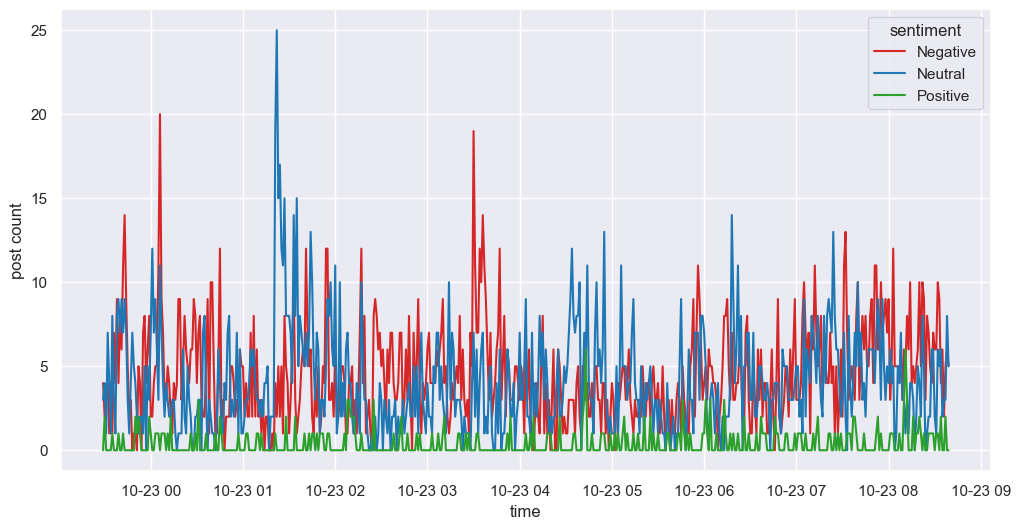

In [36]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(12, 6))
palette = {'Negative': 'tab:red',
           'Neutral': 'tab:blue',
           'Positive': 'tab:green'}
sns.lineplot(res, x='time', y='post count', hue='sentiment', palette=palette)

### Showing sentiments on separate plots for clarity
Showing all three sentiments together on a single plot is hard to interpret. Having them on separate plots might be a bit easier to make sense of

/Users/hector/anaconda3/envs/twitter-nlp/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  """


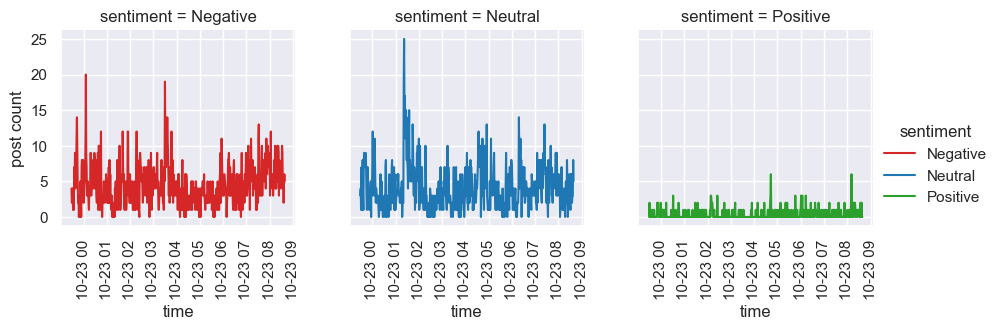

In [74]:
g = sns.FacetGrid(res, col="sentiment",  hue ="sentiment", palette=palette)
# map the above form facetgrid with some attributes
g.map(sns.lineplot, "time", "post count").add_legend()
for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
# show the object
plt.show()

### Smoothing the sentiment counts
A smoother line for each sentiment might be easier to make sense of. Here I play around with visualising the sentiment counts using a gaussian filter as per https://stackoverflow.com/questions/61799259/plot-smoothing-matplotlib-and-seaborn

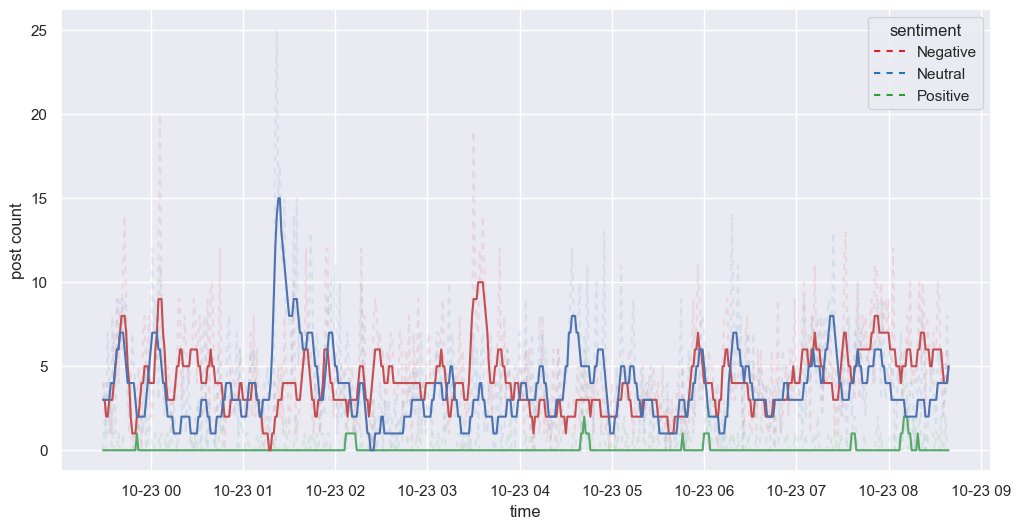

In [38]:
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt
pos_smoothed = gaussian_filter1d(res[res['sentiment']=='Positive']['post count'], sigma=2)
neg_smoothed = gaussian_filter1d(res[res['sentiment']=='Negative']['post count'], sigma=2)
neutral_smoothed = gaussian_filter1d(res[res['sentiment']=='Neutral']['post count'], sigma=2)

palette = {'Negative': 'tab:red',
           'Neutral': 'tab:blue',
           'Positive': 'tab:green'}

times = res[res['sentiment']=='Positive']['time']
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(res, x='time', y='post count', hue='sentiment', palette=palette,
                  style='sentiment', dashes=[(3, 3), (3, 3), (3, 3)],
                 alpha = 0.1)
ax.plot(times, pos_smoothed, color='g')
ax.plot(times, neg_smoothed, color='r')
ax.plot(times, neutral_smoothed, color='b')

## The pitfalls of sentiment analysis

From looking at the data we have retrieved and from reading about sentiment analysis, my personal opinion is we should treat sentiment analysis with a generous pinch of salt.

#### What question are we really asking here?

It's worth remembering that sentiment analysis models simply take a piece of text and return whether than text overall expresses a positive, negative, or neutral sentiment. It's also worth mentioning that how we frame the query to retrieve tweets affects the question we are asking.

Being pedantic this means that the question we are asking of twitter in this notebook is essentially: "What is the sentiment of tweets mentioning @trussliz". This is not quite the same as the question we really want to ask: "How does twitter feel about Liz Truss?".


#### The context of a tweet can change how we interpret its sentiment
As humans, we parse the context of a tweet as well as the content but sentiment analysis models simply take the tweet as a standalone item and tries to understand the sentiment. This is a problem as this context can fundamentally change the sentiment of a tweet. In the future, we might want to do something more advanced here, to provide sentiment analysis models with more context. For example, this tweet seems to express a relatively neutral sentiment:

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">Umm, remember <a href="https://twitter.com/trussliz?ref_src=twsrc%5Etfw">@trussliz</a></p>&mdash; 12 Long Years (@slimey_1) <a href="https://twitter.com/slimey_1/status/1583980475911053314?ref_src=twsrc%5Etfw">October 23, 2022</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script> 

but in the context of being a reply to this tweet: 

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">Party members are no fools. They know a winner when they see one <a href="https://t.co/j5kYqQkAVw">https://t.co/j5kYqQkAVw</a></p>&mdash; Lord Cruddas of Shoreditch (@peteratcmc) <a href="https://twitter.com/peteratcmc/status/1583710013495050240?ref_src=twsrc%5Etfw">October 22, 2022</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script> 

We see that it's clearly expressing negative sentiment.

Context is not just provided by other tweets. As human beings we have a knowledge of the world beyond out twitter dataset. In the example of Liz Truss, we're all sadly aware of recent events and thus can correctly interpret the sentiment of tweets which reference these events - something a language model might struggle with. Consider this tweet:

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">Liz Truss - Gone.<br><br>Lettuce - Romaine.</p>&mdash; Amanda (@Pandamoanimum) <a href="https://twitter.com/Pandamoanimum/status/1583074691211677697?ref_src=twsrc%5Etfw">October 20, 2022</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script> 

To understand that this is mocking Truss you have to be aware of the [widespread joke that a lettuce outlasted her in office](https://inews.co.uk/news/media/liz-truss-lettuce-joke-explained-uk-shortest-serving-prime-minister-1925884)

#### A given tweet can reference multiple individuals with different sentiments (multipolarity)

Importantly, the transformer sentiment analysis model only tells us whether a given tweet expresses a positive, negative, or neutral sentiment. However, we want to go one step futher and see whether these tweets are pro or anti our person of interest. As well as taking in the reply context of a tweet, we need to be careful of multipolarity. This is when a piece of text conveys multiple sentiments, often about different subjects. We need to extract the sentiment that is relevant to our person of interest.

#### Sarcasm
In general, sentiment analysis models are not very good at detecting sarcasm. As we saw earlier in this notebook, the most positive tweets were actually all retweets of a deeply sarcastic tweet from UK comedian Joe Lycett:

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">. <a href="https://twitter.com/trussliz?ref_src=twsrc%5Etfw">@trussliz</a> omg just heard there’s a leadership election nxt week????? u shud run babe youd be perfect!!! 💝💫💥</p>&mdash; Joe Lycett (@joelycett) <a href="https://twitter.com/joelycett/status/1583088316739915776?ref_src=twsrc%5Etfw">October 20, 2022</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script> 


#### Twitter specific issues
Twitter in particular can present some unique difficulties for sentiment analysis. These are:
- Variety of languages in retrieved tweets (the model used in this notebook is english only)
- Tweets often use specific vocabulary and slang not found elsewhere as frequently (this shouldn't be an issue as our model is trained specifically on twitter data)
- Tweets can be multimodal (i.e. not just text). Other items contained in tweets such as links, images, and videos, can affect the sentiment expressed.
- Use of emojis, which can confuse downstream sentiment analysis models


## Future work
What would I like to do with this work in the future? Here are some ideas:
- Expand my search query to find not just mentions of @trussliz, but tweets that reference her without her user handle
- Refine how I handle retweets and replies to see if I can incorporate context
- Try sentiment analysis approaches other than transformers
- Look at refining sentiment analysis relative to our person of interest by splitting multipolar tweets
- Investigate pre-processing approaches. Currently I only replace urls and user handles
- Package this functionality in a Flask app.

## Further reading

Interesting readers can check out this review paper [Like it or not: a survey of twitter sentiment analysis methods](http://old-eclass.uop.gr/modules/document/file.php/DIT104/%CE%92%CE%B9%CE%B2%CE%BB%CE%B9%CE%BF%CE%B3%CF%81%CE%B1%CF%86%CE%AF%CE%B1%202017-2018/Like%20It%20or%20Not%20A%20Survey%20of%20Twitter%20Sentiment%20Analysis%20Methods.pdf) which gives a review of challenges and approaches in twitter sentiment analysis.